In [1]:
import tensorflow as tf
from bayes_tec.bayes_opt.maximum_likelihood_tec import solve_ml_tec
import numpy as np
float_type = tf.float64

def test_solve():
    
    import numpy as np
    from seaborn import jointplot
    import pylab as plt
    plt.style.use('ggplot')
    freqs = np.linspace(120e6,160e6,20)
    tec_conversion = -8.448e9/freqs
    true_tec = np.random.uniform(-0.2,0.2,size=10000)#np.array([0.004]*1000)
    noise_tec = np.random.uniform(0.0001,0.01,size=10000)
    noise_rads = np.abs(noise_tec[...,None]*tec_conversion)
#     noise_rads = np.random.uniform(0.05,0.8,size=10000)#np.array([0.3]*1000)# a lot of noise on almost flat TEC is hard
    true_phase = true_tec[...,None] * tec_conversion
    phase = true_phase + noise_rads*np.random.normal(size=true_phase.shape)

    tec_min, tec_sigma = solve_ml_tec(phase,freqs,verbose=True)
    plt.scatter(true_tec,tec_min)
    plt.xlabel("True tec")
    plt.ylabel("Pred tec")
    plt.show()
   
    
    jointplot(true_tec,tec_min,kind='hex')
    plt.show()
    jointplot(true_tec,tec_min,kind='kde',alpha=0.6,marker='+',color='k')
    plt.show()
    
    plt.scatter(noise_tec, tec_sigma)
    plt.xlabel("Pred phase noise")
    plt.ylabel("True phase noise")
    plt.show()
    jointplot(noise_tec, tec_sigma,kind='hex')
    plt.show()
    jointplot(noise_tec, tec_sigma,kind='kde',alpha=0.6,marker='+',color='k')
    plt.show()
    
    plt.hist(np.log10(np.abs(true_tec - tec_min)),bins=100)
    plt.show()
    plt.hist(np.log10(np.abs(noise_tec - tec_sigma)), bins=100)
    plt.show()
    

def diagnostics():
    
    import numpy as np
    import pylab as plt
    plt.style.use('ggplot')
    freqs = np.linspace(120e6,160e6,20)
    tec_conversion = -8.448e9/freqs
    true_tec = np.random.uniform(-0.3,0.3,size=1000)#np.array([0.004]*1000)
    noise_rads = np.array([0.3]*1000)# a lot of noise on almost flat TEC is hard
    true_phase = true_tec[...,None] * tec_conversion
    phase = true_phase + noise_rads[...,None]*np.random.normal(size=true_phase.shape)
    
    _tec = true_tec[0]
    
    with tf.Session(graph=tf.Graph()) as sess:
        t_pl = tf.placeholder(float_type)
        phase_pl = tf.placeholder(float_type)
        tec_conversion_pl = tf.placeholder(float_type)
        X_init, Y_init = init_population(phase_pl,tec_conversion_pl,N=5)
        Xcur, Ycur = X_init, Y_init
        X_,Y_,aq_,fmean_,fvar_ = [],[],[],[],[]
        for i in range(21):
            res = bayes_opt_iter(phase_pl, tec_conversion_pl, Xcur, Ycur, max_tec=0.4, t = t_pl)
            X_.append(res.X)
            Y_.append(res.Y)
            aq_.append(res.aq)
            fmean_.append(res.fmean)
            fvar_.append(res.fvar)
            Xcur = res.X
            Ycur = res.Y
        X, Y, aq, fmean, fvar = sess.run([X_, Y_, aq_, fmean_, fvar_], feed_dict={t_pl:1.,
                                                                         phase_pl:phase,
                                                                        tec_conversion_pl:tec_conversion})
        
        indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
        tec_min = X[-1][indices]
        plt.scatter(tec_min, true_tec)
        plt.xlabel("pred. tec")
        plt.ylabel("true tec")
        plt.title("Scatter of solutions")
        plt.show()

        plt.hist(indices[1],bins=20)
        plt.title("Where was fmin attained")
        plt.xlabel("iteration including random init pop")
        plt.show()

        scatter = []
        for j in range(Y[-1].shape[1]):
            indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:j+1,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
            tec_j = X[-1][indices]
            scatter.append(np.percentile(np.abs(tec_j - true_tec),95))

        plt.plot(scatter)
        plt.title("95% conf interval of |true_tec - pred_tec|")
        plt.yscale('log')
        plt.xlabel("iteration")
        plt.ylabel("mean delta tec")
        plt.show()
        
        scatter = []
        for j in range(Y[-1].shape[1]):
            indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:j+1,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
            tec_j = X[-1][indices]
            scatter.append(np.percentile(np.abs(tec_j - true_tec),50))

        plt.plot(scatter)
        plt.title("50% conf interval of |true_tec - pred_tec|")
        plt.yscale('log')
        plt.xlabel("iteration")
        plt.ylabel("mean delta tec")
        plt.show()


        tec_array = np.linspace(-0.4, 0.4, 100)
        for i, (x, y, a, f, v) in enumerate(zip(X, Y, aq, fmean, fvar)):
            y = y - y.mean(1,keepdims=True)
            y = y / (np.std(y,axis=1,keepdims=True) + 1e-6)
            
            
            plt.plot(tec_array, f[0,:], label=r'$\mathbb{E}[f]$')
            plt.fill_between(tec_array, f[0,:] - 2*np.sqrt(v[0,:]), f[0,:] + 2*np.sqrt(v[0,:]),alpha=0.5, label=r'$\pm 2\sigma_f$')
            a = a - np.min(a,axis=1,keepdims=True)
            a = 3*a/np.max(a,axis=1,keepdims=True)
            plt.plot(tec_array,a[0,:],label='norm. acquisition func.')
            plt.scatter(x[0, :-1, 0], y[0,:-1, 0],c='k',label='sampled points')
            plt.scatter(x[0, -1, 0], y[0,-1, 0],c='red',label='New sample point')
            plt.vlines(_tec,-2,2,label='global. min',linestyles='--')
            plt.xlabel("tec")
            plt.ylabel("normalized neg-log-likelihood")
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
            plt.title("Iteration {}".format(i))
            plt.show()
            

2018-09-15 18:46:20,917 CACHEDIR=/home/albert/.cache/matplotlib
2018-09-15 18:46:20,921 Using fontManager instance from /home/albert/.cache/matplotlib/fontList.json
2018-09-15 18:46:20,993 backend module://ipykernel.pylab.backend_inline version unknown
2018-09-15 18:46:20,998 backend module://ipykernel.pylab.backend_inline version unknown
2018-09-15 18:46:26,015 Starting batch 0
2018-09-15 18:46:30,706 Finished batch 0 0.0% [4.690656686027069 213.18976572702198 samples/seconds 4.690656686027069 ms/sample]
2018-09-15 18:46:30,707 Starting batch 1
2018-09-15 18:46:32,342 Finished batch 1 10.0% [1.6351226420374587 611.574920615093 samples/seconds 1.6351226420374587 ms/sample]
2018-09-15 18:46:32,343 Starting batch 2
2018-09-15 18:46:33,979 Finished batch 2 20.0% [1.635665810026694 611.371830278509 samples/seconds 1.635665810026694 ms/sample]
2018-09-15 18:46:33,980 Starting batch 3
2018-09-15 18:46:35,533 Finished batch 3 30.0% [1.5530770699842833 643.8830495450684 samples/seconds 1.55307

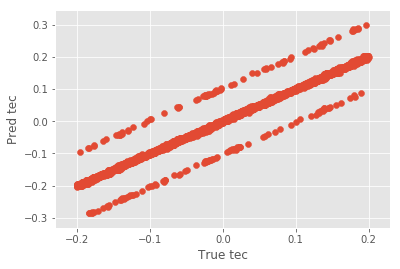

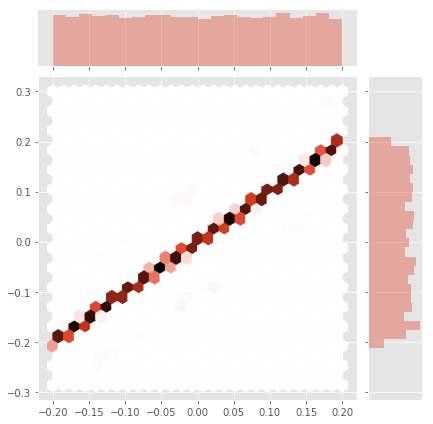

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'marker'
  s)


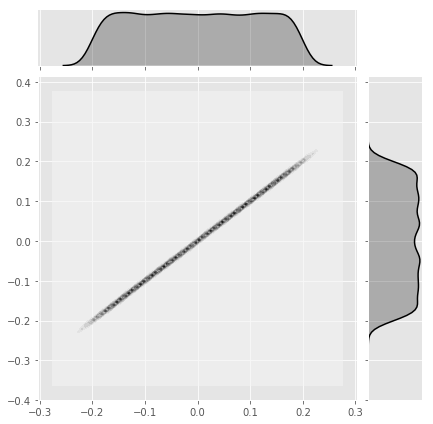

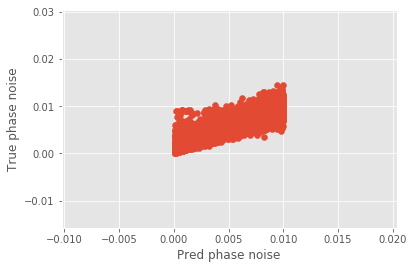

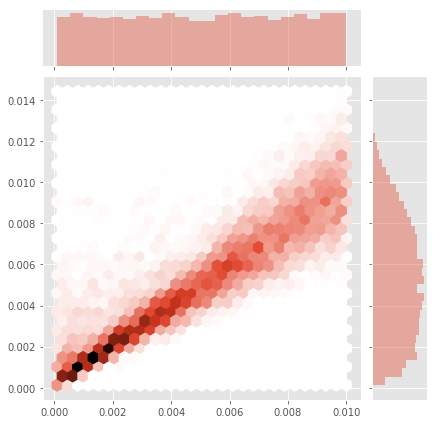

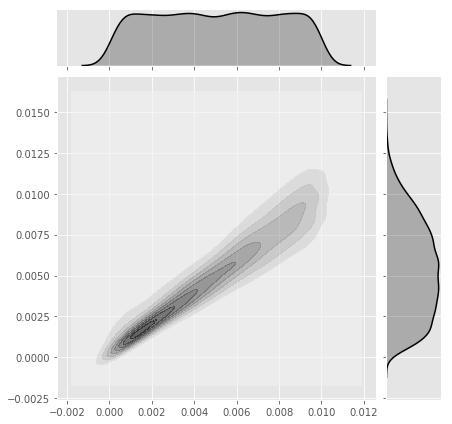

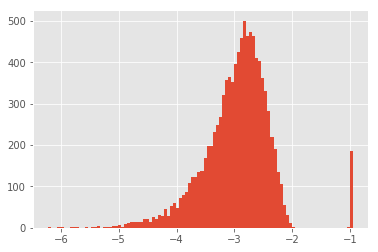

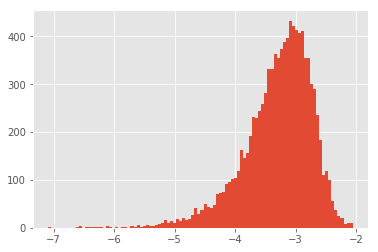

2018-09-15 18:47:03,458 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


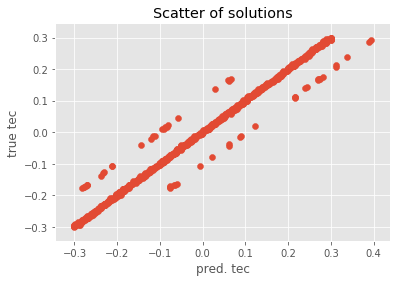

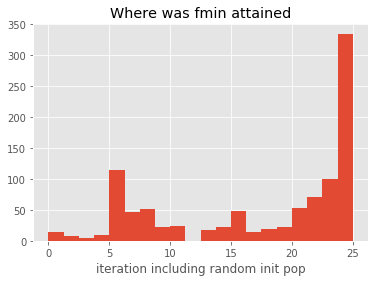

2018-09-15 18:47:03,874 findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
2018-09-15 18:47:03,881 findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
2018-09-15 18:47:03,888 findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
2018-09-15 18:47:03,895 findfont: Matching :family=STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode

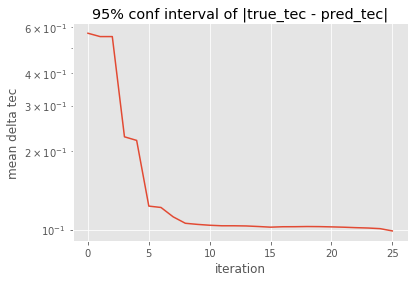

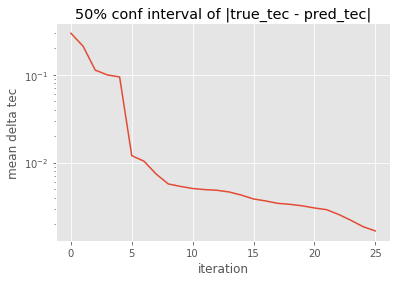

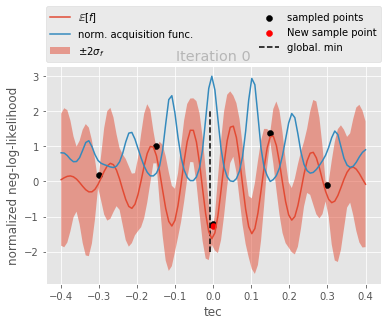

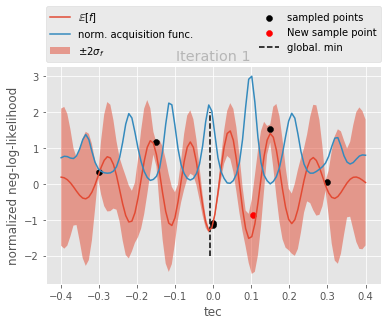

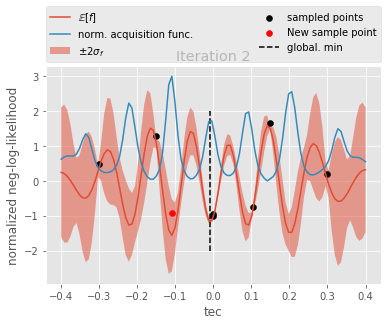

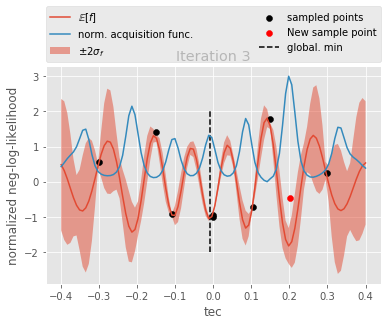

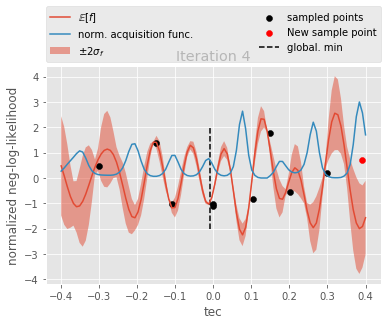

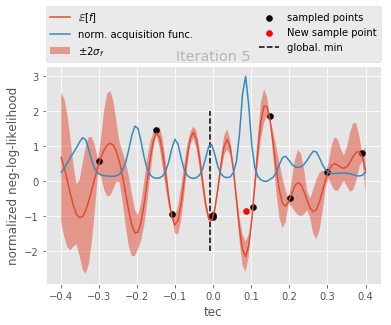

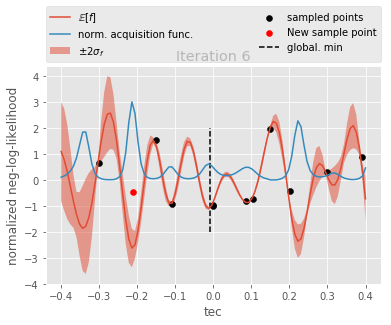

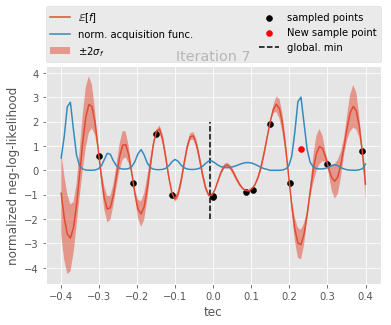

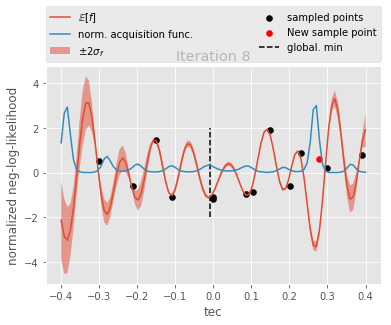

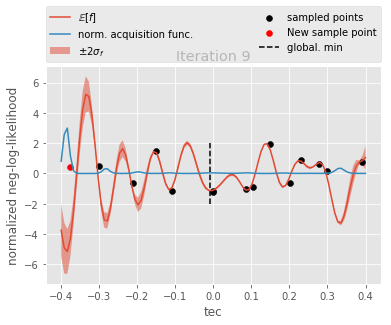

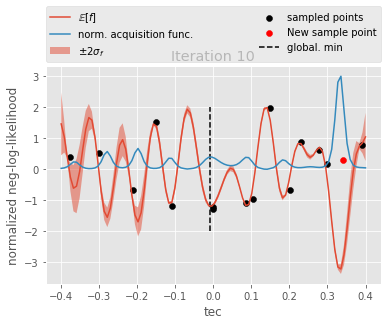

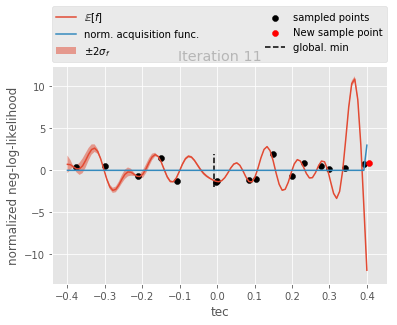

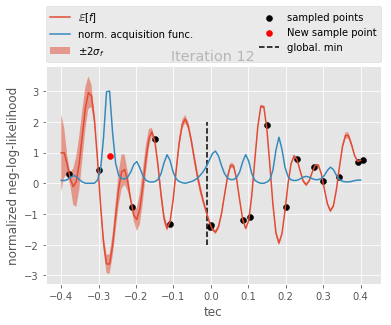

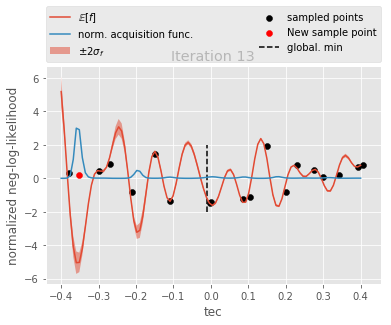

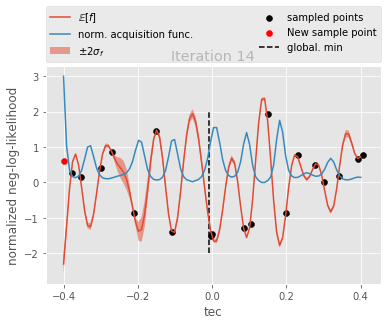

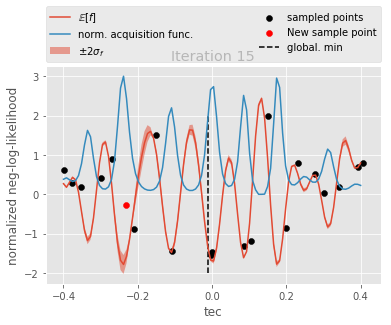

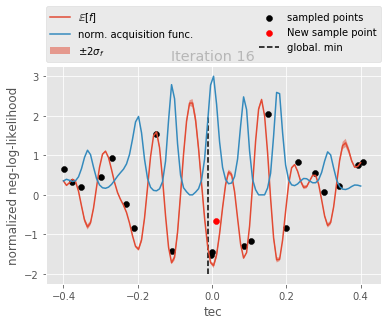

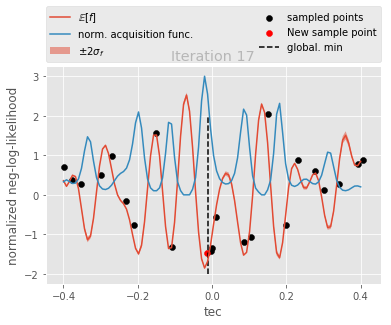

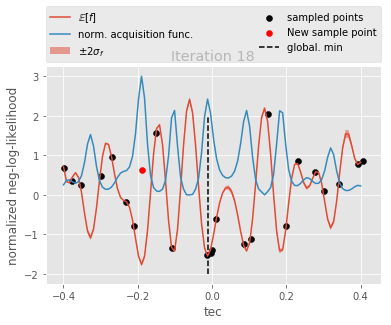

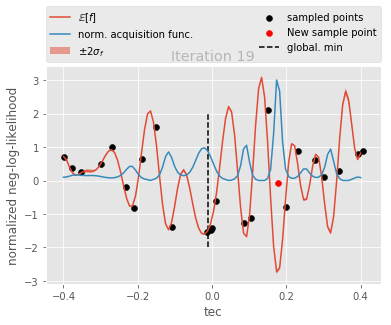

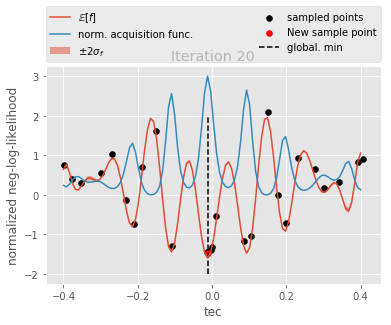

2018-09-15 18:47:09,624 backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
%matplotlib inline
test_solve()
diagnostics()